# Import Libraries

In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, f1_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import make_pipeline

In [44]:
comb = pd.read_csv("../datasets/NH3-UK/nh3_combined.csv")

# Combine the dataframs using merge function
comb['time'] = pd.to_datetime(comb['time'])

# Smoothen the data
comb = comb.drop(comb[comb['NH4_N_MGL'] > 3].index)
comb = comb.drop(comb[comb['NH4_N_MGL'] < 0].index)

# Preprocessing

79850
10150


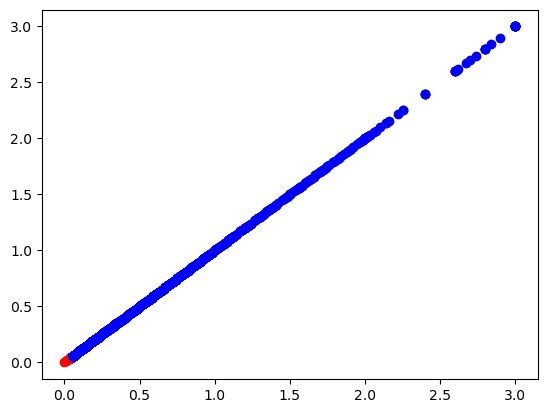

In [9]:
x = comb.sample(9000)
dec = x[x['decreaseFeed'] == 1]
print(len(dec) * 10)
man = x[x['decreaseFeed'] == 0]
print(len(man) * 10)
plt.plot(man['NH4_N_MGL'], man['NH4_N_MGL'], 'ro')
plt.plot(dec['NH4_N_MGL'], dec['NH4_N_MGL'], 'bo')
plt.show()


# Feature Selection

In [30]:
samp = comb.sample(10000)
# get hour and prevamm
samp['hour'] = samp['time'].dt.hour
samp['prev_amm'] = samp['NH4_N_MGL'].shift(1)

# drop na
samp = samp.dropna(subset=['NH4_N_MGL', 'PH', 'DO_MGL', 'hour', 'prev_amm'])

X = samp[['PH', 'pressure_msl (hPa)', 'DO_MGL', 'diffuse_radiation (W/m²)', 'temperature_2m (°C)']].values
y = samp['NH4_N_MGL'].values
regressor = RandomForestRegressor(n_estimators=50)
regressor.fit(X, y)

print(regressor.feature_importances_)

[0.12887404 0.39954869 0.2220481  0.12582496 0.12370421]


# Classification Methods

In [6]:
# split testset into training and tetsing
test = cis.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['DO_MGL','PH','precipitation (mm)','pressure_msl (hPa)', 'direct_radiation (W/m²)']], 
        test['decreaseFeed'], test_size=0.2)

In [14]:
def stats(y_pred, y_test):
    # add F1 score, ROC AUC
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tp = cm.data[0, 0]
    tn = cm.data[0, 1]
    fp = cm.data[1, 0]
    fn = cm.data[1, 1]

    print("Precision : ", tp/(tp + tn))
    print("Recall: ", tp/(tp + fp))
    print("Accuracy: ", (tp + fn)/(tp + tn + fp + fn))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [13]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

F1 Score:  0.5734518844913054
ROC AUC Score:  0.5707071421576654
[[3563 2741]
 [2680 3644]]
Precision :  0.5651967005076142
Recall:  0.5707192055101714
Accuracy:  0.5707158694963573
Mean Absolute Error (MAE): 0.4292841305036427
Root Mean Squared Error (RMSE): 0.8094428822867059


In [14]:
print("------ Polynomial SVC Results ------")
clf = make_pipeline(preprocessing.RobustScaler(), NuSVC(kernel='rbf', gamma='auto', degree=3, nu=0.5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

print("------ Exponential SVC Results ------")
clf = make_pipeline(preprocessing.QuantileTransformer(), SVC(kernel='poly', gamma='auto', degree=9))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Polynomial SVC Results ------
F1 Score:  0.5700138352872642
ROC AUC Score:  0.5322510912421297
[[2809 3495]
 [2410 3914]]
Precision :  0.4455901015228426
Recall:  0.538225713738264
Accuracy:  0.5323883433639531
Mean Absolute Error (MAE): 0.46761165663604687
Root Mean Squared Error (RMSE): 0.8269349207180704
------ Exponential SVC Results ------
F1 Score:  0.6693760984182776
ROC AUC Score:  0.5225830732653304
[[ 514 5790]
 [ 230 6094]]
Precision :  0.08153553299492386
Recall:  0.6908602150537635
Accuracy:  0.5232815964523282
Mean Absolute Error (MAE): 0.47671840354767187
Root Mean Squared Error (RMSE): 0.8309319906542257


In [17]:
print("------ Boosting Results ------")
model = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingClassifier(learning_rate=0.01, max_depth=3, criterion='squared_error'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Bagging Results ------")
# import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clf = make_pipeline(preprocessing.QuantileTransformer(), BaggingClassifier(n_jobs=5, base_estimator=DecisionTreeClassifier(), n_estimators=100))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)


print("------ Stacking Results ------")
neural = ('nn', make_pipeline(preprocessing.SplineTransformer(), MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', max_iter=200000)))
clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=24, criterion='entropy', max_features='sqrt')), 
    ('svm', SVC(kernel='rbf')),
    ('gb', GradientBoostingClassifier(max_depth=2))
    ])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Boosting Results ------
F1 Score:  0.6149165236386331
ROC AUC Score:  0.6091002831048908
[[3751 2553]
 [2383 3941]]
Precision :  0.595019035532995
Recall:  0.6115096185197261
Accuracy:  0.6091225847323408
Mean Absolute Error (MAE): 0.3908774152676592
Root Mean Squared Error (RMSE): 0.7906970972523976
------ Bagging Results ------
F1 Score:  0.7867986798679868
ROC AUC Score:  0.7954410640955252
[[5276 1028]
 [1556 4768]]
Precision :  0.8369289340101523
Recall:  0.772248243559719
Accuracy:  0.7953753563509661
Mean Absolute Error (MAE): 0.2046246436490339
Root Mean Squared Error (RMSE): 0.6725730854285915
------ Stacking Results ------
F1 Score:  0.8112538419103159
ROC AUC Score:  0.8103364790324186
[[5086 1218]
 [1177 5147]]
Precision :  0.8067893401015228
Recall:  0.8120708925435095
Accuracy:  0.8103420969274627
Mean Absolute Error (MAE): 0.18965790307253722
Root Mean Squared Error (RMSE): 0.659922196528531


In [16]:
print("------ KNN Results ------")
from sklearn.neighbors import KNeighborsClassifier
k = 2 
knn = KNeighborsClassifier(n_neighbors=k)
# Train the kNN classifier
knn.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)
stats(y_pred, y_test)

print("------ Decision Tree Results ------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Random Forest Results ------")
clf = RandomForestClassifier(max_depth=40, criterion='gini', max_features='log2')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ KNN Results ------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


F1 Score:  0.5824532900081235
ROC AUC Score:  0.6747247613635269
[[5648  656]
 [3456 2868]]
Precision :  0.8959390862944162
Recall:  0.6203866432337434
Accuracy:  0.6743744060817232
Mean Absolute Error (MAE): 0.32562559391827683
Root Mean Squared Error (RMSE): 0.7554046140487042
------ Decision Tree Results ------
F1 Score:  0.6988279259385086
ROC AUC Score:  0.7193043501992249
[[4968 1336]
 [2210 4114]]
Precision :  0.7880710659898477
Recall:  0.6921147952075787
Accuracy:  0.7191954387076338
Mean Absolute Error (MAE): 0.2808045612923662
Root Mean Squared Error (RMSE): 0.7279491437142798
------ Random Forest Results ------
F1 Score:  0.796165820088481
ROC AUC Score:  0.8030324511088207
[[5281 1023]
 [1465 4859]]
Precision :  0.8377220812182741
Recall:  0.7828342721612808
Accuracy:  0.8029775102945834
Mean Absolute Error (MAE): 0.19702248970541653
Root Mean Squared Error (RMSE): 0.6662373110880252


# Deep Learning

In [24]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        #'PH_DO', 'Pressure_DO', 'RH_DO', 'CloudCover_DO', 'Temp_DO','DiffuseRad_DO', 'Precip_DO', 'RH_PH', 'RH_Pressure'
        dataframe.rename(columns={'PH': 'ph', 'pressure_msl (hPa)': 'pressure', 'relative_humidity_2m (%)': 'humid', 'diffuse_radiation (W/m²)': 'light', 'temperature_2m (°C)': 'temperature', 'DO_MGL': 'do'}, inplace=True)
        self.numeric_columns = ['ph','do', 'temperature', 'hour']
        self.transformer = preprocessing.RobustScaler()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns])
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['NH4_N_MGL']).reset_index(drop=True)

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['NH4_N_MGL'].iloc[idx].astype(np.float32)
        
        # Reshape the inputs to have a shape of [num_channels, sequence_length]
        # In this case, sequence_length is 1 since each feature is a single value.
        inputs = torch.tensor(inputs).view(len(self.numeric_columns), 1)
        label = torch.tensor(label).view(1)
        
        return inputs, label

In [4]:
class Prev_NH4_Dataset(MyDataset):
    def __init__(self, dataframe, previous_ammonia_list=None):
        self.data = dataframe
        self.numeric_columns = ['ph', 'do', 'temperature', 'hour']
        self.transformer = preprocessing.RobustScaler()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns])
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['previous_ammonia']).reset_index(drop=True)
        
        if previous_ammonia_list is not None:
            self.previous_ammonia = previous_ammonia_list
        else:
            self.previous_ammonia = self.data['previous_ammonia'].tolist()

    def __getitem__(self, idx):
        label = self.data['NH3_MGL'].iloc[idx].astype(np.float32)
        label = torch.tensor(label)

        # Add the previous_ammonia value from the list
        numeric_data = [self.data[col].iloc[idx] for col in self.numeric_columns]
        numeric_data.append(self.previous_ammonia[idx])
        numeric_data = torch.tensor(numeric_data)

        return numeric_data, label


Artifical Neural Network

In [34]:
input_size = 4

# Simple ANN
class CustomANN(nn.Module):
    def __init__(self):
        super(CustomANN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.CELU(),
            nn.Linear(16, 32),
            nn.CELU(),
            nn.Linear(32, 8),
            nn.CELU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x.float())
        return x * 5  # Scaling the Sigmoid output to range from 0 to 5
ann = CustomANN()

class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[-1, :]

# Simple GRU
gru = nn.Sequential(
    nn.GRU(input_size=input_size, hidden_size=12, num_layers=5, batch_first=True),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(12, input_size),
    nn.Sigmoid()
)

# Simple RNN
rnn = nn.Sequential(
    nn.RNN(input_size=input_size, hidden_size=12, num_layers=5, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(12, 1),
)

# Simple LSTM
lstm = nn.Sequential(
    nn.LSTM(input_size=input_size, hidden_size=16, num_layers=7 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(16, 1)
)

# Simple 1D ConvNet

class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=1, padding=0),  # Changed input channels to 4 and increased filters to 16
            nn.ReLU(),  # Changed activation to ReLU
            nn.Conv1d(16, 32, kernel_size=1, padding=0),  # Increased filters to 32
            nn.ReLU(),  # Changed activation to ReLU
            nn.Flatten(),
            nn.Linear(32, 64),  # Adjusted based on the output size of the previous layer
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)

# Multihead Attention Network
class AttentionNet1(nn.Module):
    def __init__(self):
        super(AttentionNet1, self).__init__()
        self.attention = nn.MultiheadAttention(input_size, num_heads=5)
        self.final = CustomANN()
        
    def forward(self, x):
        out, _ = self.attention(x, x, x)
        return self.final(out)

class TransformerNet1(nn.Module):
    def __init__(self):
        super(TransformerNet1, self).__init__()
        self.transformer = nn.Transformer(d_model=4, nhead=2, num_encoder_layers=5, num_decoder_layers=5, dim_feedforward=64, dropout=0.2)
        self.activation = nn.CELU()
        self.linear = nn.Linear(4, 4)
        self.customann = CustomANN()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        transformer_out = self.transformer(x, x)
        activated_out = self.activation(transformer_out)
        out = self.linear(activated_out)
        out = self.activation(out)
        out = self.customann(out)
        out = self.sigmoid(out)
        return out


In [35]:
model = ConvNet1()

loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.005)
num_epochs = 3

comb['NH3_N_MGL'] = comb['NH4_N_MGL'] * np.power(10, (comb['PH'] - 9.25))
test = comb.copy(True)

# split testset into training and tetsing
trainset, testset = train_test_split(test, test_size=0.02)

dataset = MyDataset(trainset)
data_loader = DataLoader(dataset, drop_last=True, batch_size=1, shuffle=True)


print(model)
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        labels = labels.view(outputs.shape)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += abs(loss.item())

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

ConvNet1(
  (main): Sequential(
    (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=32, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Epoch 1, Training Loss: 0.0140
Epoch 2, Training Loss: 0.0136
Epoch 3, Training Loss: 0.0135


In [36]:
y_test_all = []
y_pred_all = []

dataset = MyDataset(testset)
data_loader = DataLoader(dataset, drop_last=True, batch_size=1, shuffle=True)

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in data_loader:
        
        # Forward pass to get predictions
        y_pred = model(inputs)
        
        # Ensure labels and predictions are of the same shape
        labels = labels.view(y_pred.shape)
        
        # Convert tensors to numpy arrays and flatten them
        y_pred_flat = y_pred.cpu().numpy().flatten()
        y_test_flat = labels.cpu().numpy().flatten()
        
        # Append to the lists
        y_pred_all.extend(y_pred_flat)
        y_test_all.extend(y_test_flat)

# Convert lists to numpy arrays
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

# Assuming the stats function calculates metrics for regression and accepts predicted and actual values
stats(y_pred_all, y_test_all)

R2 Score: 0.1026
Mean Absolute Error (MAE): 0.07601359
Root Mean Squared Error (RMSE): 0.42968099762591583


## Neural Network Vis

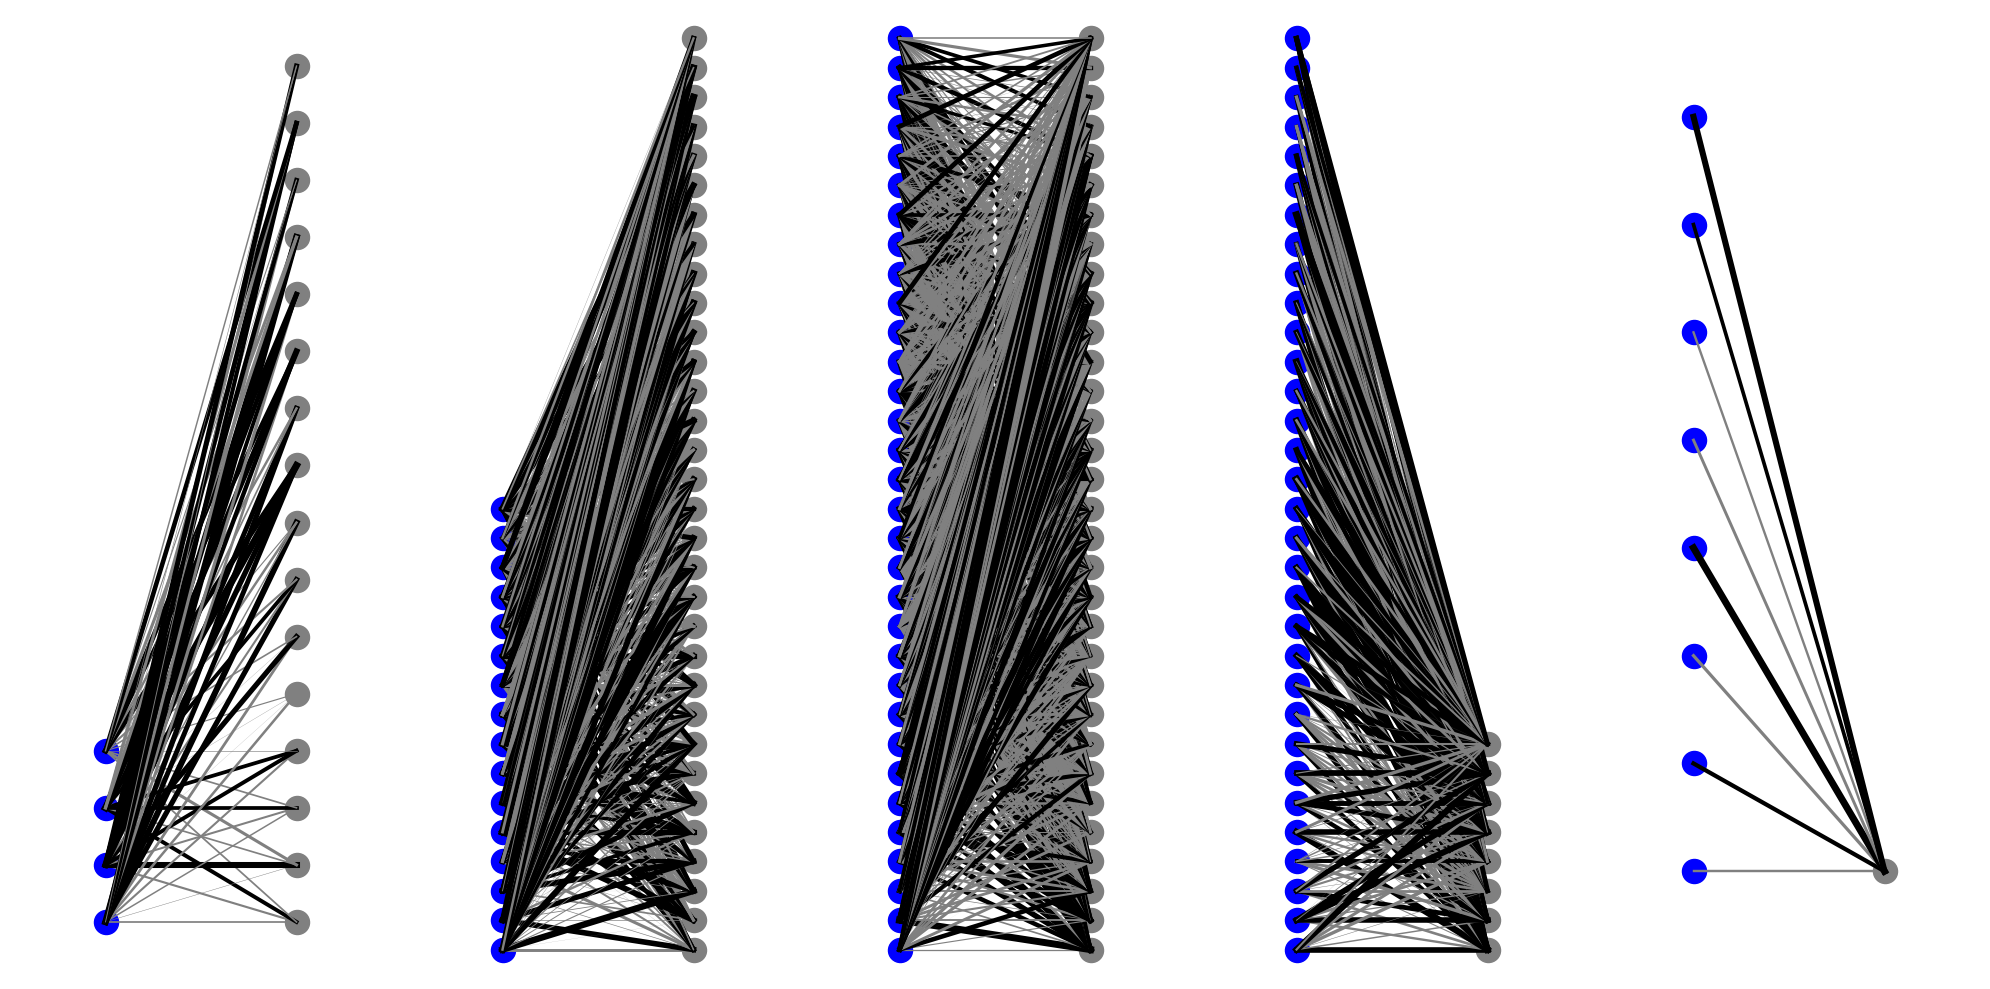

In [189]:
def plot_ann(model):
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    fig, axs = plt.subplots(1, len(layers), figsize=(20, 10))

    for i, layer in enumerate(layers):
        weights = layer.weight.data.abs().numpy()
        max_weight = weights.max()

        # Extracting number of neurons in the current and next layer
        n_neurons_in = weights.shape[1]
        n_neurons_out = weights.shape[0]

        # Plotting neurons of the current layer
        axs[i].scatter([i] * n_neurons_in, range(n_neurons_in), s=300, c='blue')

        # Plotting neurons of the next layer
        axs[i].scatter([i + 1] * n_neurons_out, range(n_neurons_out), c='gray', s=300)

        # Connecting lines (weights) between neurons of the current and next layer
        for j, neuron_out in enumerate(weights):
            for k, neuron_in in enumerate(neuron_out):
                color = 'black' if neuron_in >= 0.5 * max_weight else 'gray'
                axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)

        axs[i].set_xlim(i - 0.5, i + 1.5)
        axs[i].set_ylim(-1, max(n_neurons_in, n_neurons_out))
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
plot_ann(model.main)

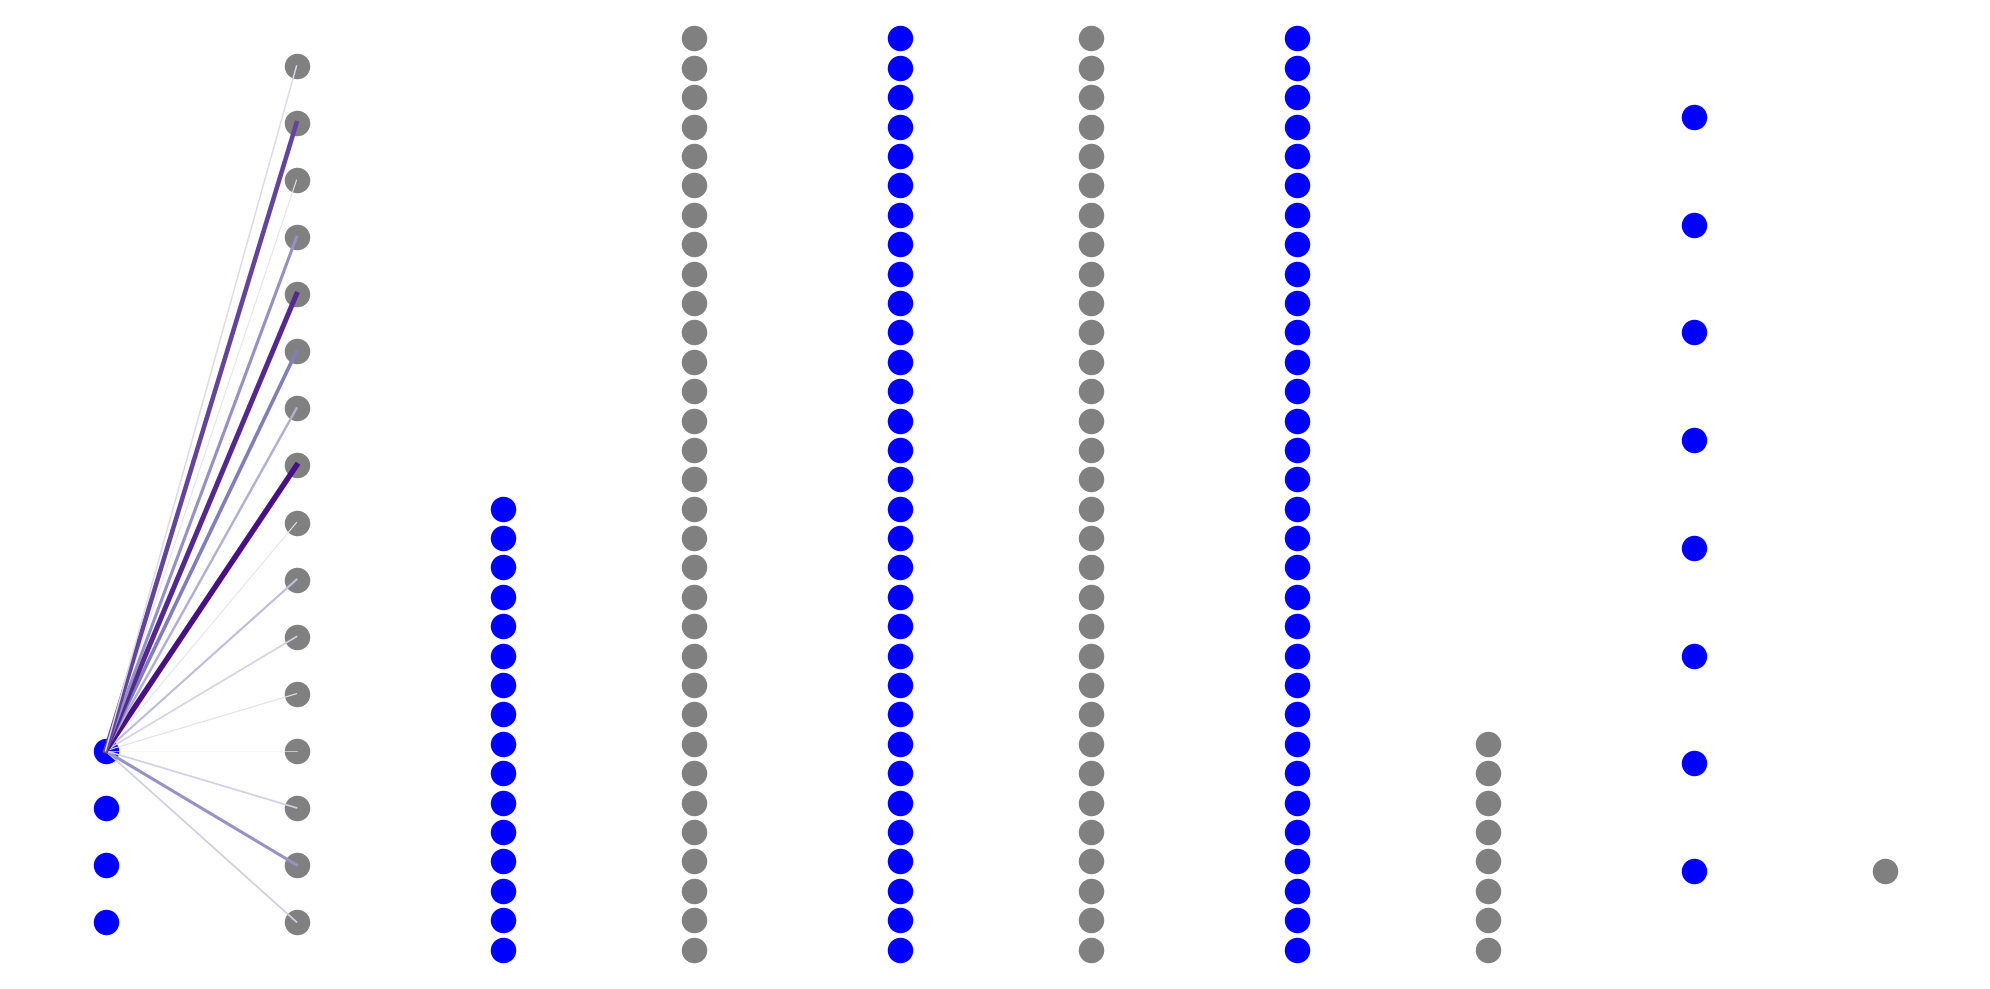

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

def plot_ann(model, node_to_highlight=None):
    layers = [module for module in model if isinstance(module, nn.Linear)]
    
    fig, axs = plt.subplots(1, len(layers), figsize=(20, 10))
    
    for i, layer in enumerate(layers):
        weights = layer.weight.data.abs().numpy()
        max_weight = weights.max()

        # Extracting number of neurons in the current and next layer
        n_neurons_in = weights.shape[1]
        n_neurons_out = weights.shape[0]

        # Plotting neurons of the current layer
        axs[i].scatter([i] * n_neurons_in, range(n_neurons_in), s=300, c='blue')

        # Plotting neurons of the next layer
        axs[i].scatter([i + 1] * n_neurons_out, range(n_neurons_out), s=300, c='gray')

        # Connecting lines (weights) between neurons of the current and next layer
        for j, neuron_out in enumerate(weights):
            for k, neuron_in in enumerate(neuron_out):
                if node_to_highlight:
                    layer_idx, neuron_idx = node_to_highlight
                    if (i == layer_idx and k == neuron_idx) or (i + 1 == layer_idx and j == neuron_idx):
                        color_intensity = neuron_in / max_weight
                        color = plt.cm.Purples(np.clip(color_intensity * 1.2, 0, 1))
                        axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)
                else:
                    color_intensity = neuron_in / max_weight
                    color = plt.cm.Purples(color_intensity)
                    
                    axs[i].plot([i, i + 1], [k, j], c=color, lw=neuron_in * 5 / max_weight)

        axs[i].set_xlim(i - 0.5, i + 1.5)
        axs[i].set_ylim(-1, max(n_neurons_in, n_neurons_out))
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
plot_ann(ann.main, node_to_highlight=(0, 3))
# ['ph','do', 'temperature', 'hour']


# Testing on DB Data

In [64]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

df = pd.read_csv("../datasets/Sensor-predict/spark-july-16.csv")
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
df['datetime'] = pd.to_datetime(df['datetime'])
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/Sensor-predict/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp', 'surface_pressure (hPa)':'pressure'}, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])

# get hour and prevamm
df['hour'] = df['datetime'].dt.hour

x_train = pd.DataFrame()
df['depth'] = 1.2192
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

import pickle
    
df = df.rename(columns={'light': 'global_light_energy_w_m2', 'airtemp': 'airtemp_oc', 'humid': 'humid_rh', 'temperature': 'temperature_oc'})
do_pred = predict(df[['global_light_energy_w_m2', 'ph', 'temperature_oc', 'humid_rh', 'airtemp_oc','depth', 'hour']])
df['DO_MGL'] = do_pred

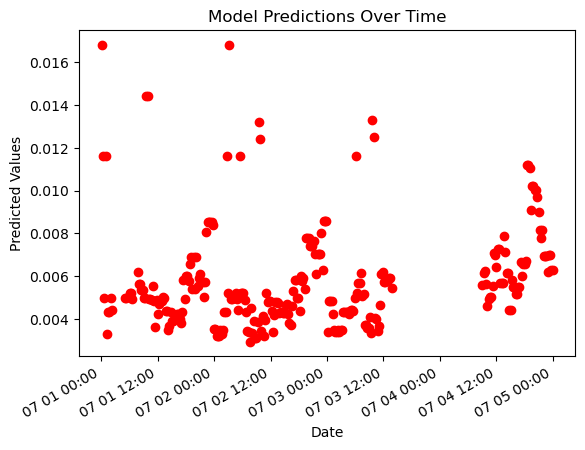

In [71]:
# test the neural net model and store its result in the pandas df
y_test_all = []
y_pred_all = []

# Initialize the previous_ammonia_values list
df['previous_ammonia'] = 0.5
df['NH4_N_MGL'] = 0.5
previous_ammonia_values = [0.5] * len(df)
# df_copy = df.copy(True)
# dataset = MyDataset(df_copy)
# data_loader = DataLoader(dataset, shuffle=False, batch_size=1)

y_pred_all = []


# with torch.no_grad():
#     for idx, (inputs, labels) in enumerate(data_loader):
#         # Forward pass to get predictions
#         y_pred = model(inputs.float())
        
#         # Convert tensors to numpy arrays and flatten them
#         y_pred_flat = y_pred.cpu().numpy().flatten()
        
#         # Append to the lists
#         y_pred_all.extend(y_pred_flat)
        
#         # Use the predicted value for the next prediction
#         # Update the next instance's previous_ammonia value with the current prediction
#         # if idx < len(data_loader) - 1:  # Ensure there's a next instance to update
#         #     previous_ammonia_values[idx+1] = y_pred_flat[0]

# df['NH4_predicted'] = y_pred_all
# df['NH3_predicted'] = df['NH4_predicted'] * np.power(10, (df['ph'] - 9.25))
# df['TAN_predicted'] = df['NH4_predicted'] + df['NH3_predicted']

# drop outliers greater than 0.12
#df = df[df['CNN_NH3'] < 0.12]

df['RF'] = xg_boost.predict(df[['ph', 'DO_MGL', 'hour', 'temperature_oc', 'global_light_energy_w_m2']])


bet = df.loc[df['datetime'].between('2023-07-01', '2023-07-05')]


# Plot the predictions over time
fig, ax = plt.subplots()
ax.plot(bet['datetime'], bet['RF'].astype(float), 'ro')


# Format the date labels on the x-axis
myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Model Predictions Over Time')
plt.show()

# Code Interpreter Supported

In [4]:
cis = pd.read_csv("../datasets/upsampled_data.csv")
cis.columns

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/upsampled_data.csv'

# Regression

In [45]:
from sklearn.metrics import r2_score

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [57]:
# import missing libraries
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# split train and test
test = comb.copy(True)
test = test.head(len(test))
# get hour
print(test.columns)
test['time'] = pd.to_datetime(test['time'])
test['hour'] = test['time'].dt.hour
# get previous ammonia as feature
test['prev_amm'] = test['NH4_N_MGL'].shift(1)
test = test.dropna(subset=['prev_amm'])

#['global_light_energy_w_m2', 'ph', 'temperature_oc', 'humid_rh', 'airtemp_oc','depth', 'hour'
test.rename(columns={'diffuse_radiation (W/m²)': 'global_light_energy_w_m2', 'temperature_2m (°C)': 'temperature_oc', 'relativehumidity_2m (%)': 'humid_rh', 'PH': 'ph' }, inplace=True)

X_train,X_test,y_train,y_test = train_test_split(test[['ph', 'DO_MGL', 'hour', 'temperature_oc', 'global_light_energy_w_m2']], test['NH3_MGL'], test_size=0.2)

Index(['Site_Code', 'X', 'Y', 'DO_MGL', 'NO3_N_MGL', 'NO2_N_MGL', 'NH4_N_MGL',
       'PH', 'time', 'hour', 'previous_ammonia', 'NH3_MGL',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'pressure_msl (hPa)',
       'precipitation (mm)', 'cloudcover (%)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)'],
      dtype='object')


In [59]:
print("------------ Exponential SVR Results ------------")
svm_spline = make_pipeline(preprocessing.SplineTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
svm_spline.fit(X_train, y_train)
y_pred = svm_spline.predict(X_test)
stats(y_pred, y_test)

print("------------ Exponential SVR Results ------------")
svm_minmax = make_pipeline(preprocessing.MinMaxScaler(), SVR(kernel='rbf', shrinking=True, C=1))
svm_minmax.fit(X_train[:len(X_train)//2], y_train[:len(X_train)//2])
svm_minmax.fit(X_train[len(X_train)//2:], y_train[len(X_train)//2:])
y_pred = svm_minmax.predict(X_test)
stats(y_pred, y_test)

------------ Exponential SVR Results ------------
R2 Score: -69.9346
Mean Absolute Error (MAE): 0.08219115750479779
Root Mean Squared Error (RMSE): 0.28834605361987037
------------ Exponential SVR Results ------------
R2 Score: -26.2094
Mean Absolute Error (MAE): 0.04252989581612947
Root Mean Squared Error (RMSE): 0.22692340644478834


In [60]:
print("------------ Random Forest Results ------------")
rf_regressor = make_pipeline(preprocessing.MaxAbsScaler(), RandomForestRegressor(n_estimators=24, max_depth=20))
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
stats(y_pred, y_test)

print("------------ Poly Regression Results ------------")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Initialize and fit the linear regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
# Predict the target variable for training and test sets
y_pred = poly_reg.predict(X_test_poly)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = make_pipeline(preprocessing.MinMaxScaler(), DecisionTreeRegressor(max_depth=24))
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error'))
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

------------ Random Forest Results ------------
R2 Score: 0.0649
Mean Absolute Error (MAE): 0.003021204121711201
Root Mean Squared Error (RMSE): 0.09770333789645821
------------ Poly Regression Results ------------
R2 Score: -0.7136
Mean Absolute Error (MAE): 0.004375271134450984
Root Mean Squared Error (RMSE): 0.11367804631618661
------------ Decision Tree Results ------------
R2 Score: -1.4503
Mean Absolute Error (MAE): 0.0038542453613643673
Root Mean Squared Error (RMSE): 0.1243090473949936
------------ XG Boost Results ------------
R2 Score: 0.1460
Mean Absolute Error (MAE): 0.0023828539917421106
Root Mean Squared Error (RMSE): 0.09551422107756911


In [52]:
# Neural Network
print("------ Neural Network Results ------")
from sklearn.neural_network import MLPRegressor
nn = make_pipeline(preprocessing.RobustScaler(), MLPRegressor(hidden_layer_sizes=(7,5), activation='tanh'))
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
stats(y_pred_nn, y_test)

------ Neural Network Results ------
R2 Score: 0.0186
Mean Absolute Error (MAE): 0.0050876192769922345
Root Mean Squared Error (RMSE): 0.13343335234478906


In [34]:
# Bagging
print("------ Bagging Results ------")
bagging = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(n_estimators=10))
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)
stats(y_pred_bagging, y_test)

# LinearRegression
print("------ LinearRegression Results ------")
linear_regression = make_pipeline(preprocessing.StandardScaler(), LinearRegression())
linear_regression.fit(X_train, y_train)
y_pred_lr = linear_regression.predict(X_test)
stats(y_pred_lr, y_test)

# Stacking
print("------ Stacking Results ------")
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

model = StackingRegressor(estimators=[
    ('svr', SVR(kernel='rbf', shrinking=False, C=2.5)), 
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(5,7), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(5,5), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

------ Bagging Results ------
R2 Score: -0.0597
Mean Absolute Error (MAE): 0.08819824246696129
Root Mean Squared Error (RMSE): 0.44032280409130914
------ LinearRegression Results ------
R2 Score: 0.0340
Mean Absolute Error (MAE): 0.08381958845469162
Root Mean Squared Error (RMSE): 0.4302558534959071
------ Stacking Results ------
R2 Score: 0.0784
Mean Absolute Error (MAE): 0.0773310459780305
Root Mean Squared Error (RMSE): 0.42522266482169313


In [ ]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Make predictions on the test data
y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred.reshape(-1, 1)})

In [ ]:
df = pd.read_csv("../datasets/spark-july-16.csv")
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
df['datetime'] = pd.to_datetime(df['datetime'])
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp' }, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])
df.rename(columns={'temperature': 'temperature_2m (°C)', 'light': 'global_light_energy_w_m2', 'humid': 'relativehumidity_2m (%)', 'airtemp': 'airtemp_oc', 'surface_pressure (hPa)': 'pressure_msl (hPa)'}, inplace=True)

x_train = pd.DataFrame()
df['depth'] = 1.2192
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
x_train = df[['ph', 'pressure_msl (hPa)', 'relativehumidity_2m (%)', 'temperature_2m (°C)', 'hour']]
'PH', 'pressure_msl (hPa)', 'DO_MGL', 'diffuse_radiation (W/m²)', 'hour', 'temperature_2m (°C)', 'relativehumidity_2m (%)', 'prev_amm'

# test the neural net model and store its result in the pandas df
'''
y_test_all = []
y_pred_all = []

dataset = MyDataset(x_train)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:

        # Forward pass to get predictions
        y_pred = model(inputs)

        # Convert the predictions and targets to numpy arrays
        y_pred_np = y_pred.numpy()
        y_pred_all.append(y_pred_np)

# Concatenate the lists into a single array
y_pred_all = np.concatenate(y_pred_all)
df['DeepNN'] = y_pred_all
'''


In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

y_pred = svm_spline.predict(x_train)
df['Spline'] = y_pred

fig, ax = plt.subplots()
bet = df.loc[df['datetime'].between('2023-06-23', '2023-06-25')]

ax.plot(bet['datetime'], bet['Spline'].astype(float), 'go')

myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()

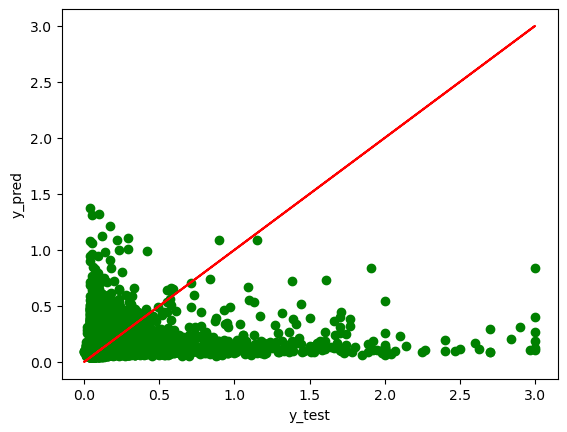

In [27]:
# plot df['y_test'] vs df['y_pred']
plt.plot(df['y_test'], df['y_pred'], 'go')
plt.plot(df['y_test'], df['y_test'], 'r')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

# Playground

In [53]:
def predict(X_test):
    # Load pickle file from ./weights
    with open('./weights/do_svm_spline.pkl', 'rb') as f:
        svm_spline = pickle.load(f)

    with open('./weights/do_svm_robust.pkl', 'rb') as f:
        svm_robust = pickle.load(f)

    with open('./weights/do_ridge.pkl', 'rb') as f:
        ridge = pickle.load(f)

    # run predict on all models and average the results
    svm_spline_pred = svm_spline.predict(X_test)
    svm_robust_pred = svm_robust.predict(X_test)
    ridge_pred = ridge.predict(X_test)

    # average the results
    pred = (svm_spline_pred * 5.2 + svm_robust_pred * 4.8 + ridge_pred * 1.7) / (5.2 + 4.8 + 1.7)
    return pred
        